# Two-parameter family of ODE solutions aka Process

$\min_\theta \mathop{\mathbb{E}}_{(I,J) \sim T, t \sim U[0,1]} ||J(\phi_\theta(I,J,0,t))-I(\phi_\theta(I,J,0,t-1))|| + \lambda \{|| \phi_\theta(I,J,t,t-1) \circ \phi_\theta(I,J,0,t) - \phi_\theta(I,J,0,t-1)|| + ||\phi_\theta(I,J,t-1,t) \circ \phi_\theta(I,J,0,t-1) - \phi_\theta(I,J,0,t)||\}$,

where $I$ and $J$ are images being registered and they are sampled from a training set $T$. $\phi_\theta(I,J,t1,t2) = (x,y) + (t2-t1)f_\theta(I,J,t1,t2)$ denotes a deformed grid/diffeomorphism, where $f_\theta$ is a neural network model, such as a Unet, with tunable parameters $\theta$. $I(\phi_\theta(I,J,0,t-1))$ and $J(\phi_\theta(I,J,0,t))$ denote warping of images $I$ and $J$ by the deformed grids $\phi_\theta(I,J,0,t-1)$ and $\phi_\theta(I,J,0,t)$, respectively. The symbol $\circ$ implies composition between two functions. Use interpolation to realize composition. $\lambda$ is the weight hyperparameter. $U$ denotes uniform distribution.

## Follow instructions to complete tasks
### Do not edit the following cell including new imports

In [1]:
# Do not edit this cell including any new imports

import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.color import rgb2gray
import torch.optim as optim
from skimage import io
from skimage.filters import gaussian
from skimage.transform import pyramid_gaussian
from torchvision.transforms.functional import gaussian_blur, resize, pad
from torch.nn.functional import interpolate
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import cv2

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### You can only edit folder paths to read images - do not edit anything else

512 512


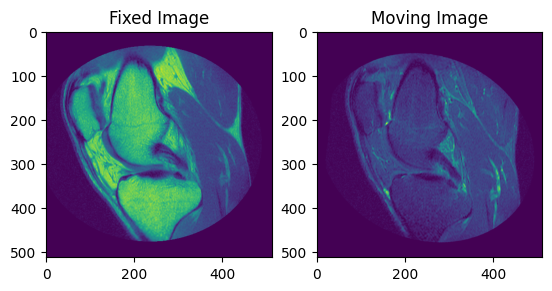

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

I = io.imread("knee1.bmp").astype(np.float32)/255.0
J = io.imread("knee2.bmp").astype(np.float32)/255.0

I_ = torch.tensor(gaussian(I,1.0).astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)
J_ = torch.tensor(gaussian(J,1.0).astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)

# I_ = pad(I_, 2)
# J_ = pad(J_, 2)

h_ = I_.shape[2]
w_ = I_.shape[3]

y_, x_ = np.meshgrid(np.arange(0,h_), np.arange(0,w_),indexing='ij')
y_, x_ = 2.0*y_/(h_-1) - 1.0, 2.0*x_/(w_-1) - 1.0

xy_ = torch.tensor(np.stack([x_,y_],2),dtype=torch.float32).unsqueeze(0).to(device)

print(h_, w_)
%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(I)
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(J)
plt.title("Moving Image")
plt.show()

### You have full control to edit the following cell to define your own time-embedded U-net / other architecture

#### The architecture given below is from the one parameter solution notebook

In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()

    self.dim = dim

  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

    return embeddings

class Block2d(nn.Module):
  def __init__(self, in_channels, out_channels, time_emb_dim, up=False):
    super().__init__()

    self.time_mlp =  nn.Linear(time_emb_dim, out_channels)

    if up:
      # up-sampling (decoder part)
      self.conv1 = nn.Conv2d(2*in_channels, out_channels, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
      #self.transform = nn.Sequential(nn.Conv2d(out_channels,out_channels,3,padding=1),
      #                               torch.nn.Upsample(scale_factor=2, mode='bilinear'))
    else:
      # down-sampling (encoder part)
      self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
      self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)

    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
    self.bnorm1 = nn.BatchNorm2d(out_channels)
    self.bnorm2 = nn.BatchNorm2d(out_channels)

    self.t_embed = SinusoidalPositionEmbeddings(time_emb_dim)

  def forward(self, x:torch.Tensor, t: torch.Tensor):
    # First Conv
    h = self.bnorm1(F.silu(self.conv1(x)))
    # Time embedding

    # print("t", t.shape)
    # print("t", t.shape)
    # t_enc = self.t_embed(t)
 

    # print("t_enc", t_enc.shape)
    # print("x", x.shape)




    time_emb = F.silu(self.time_mlp(t[1][None, :] - t[0][None, :]))
    # Extend last 2 dimensions
    time_emb = time_emb[(..., ) + (None, ) * 2]
    # Add time channel
    h = h + time_emb
    # Second Conv
    h = self.bnorm2(F.silu(self.conv2(h)))

    # Down or Upsample
    out = self.transform(h)

    return out

class UNet(nn.Module):
  """
  A simplified variant of the Unet architecture.
  """
  def __init__(self, in_channels=1, out_channels=1, time_emb_dim=32):
    super().__init__()

    down_channels = (8, 16, 64, 512)
    up_channels = (512, 64, 16, 8)


    # Time embedding
    self.time_mlp = nn.Sequential(
        SinusoidalPositionEmbeddings(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.SiLU()
    )

    # Initial projection
    self.conv0 = nn.Conv2d(in_channels, down_channels[0], 3, padding=1)

    # Downsample
    self.downs = nn.ModuleList([Block2d(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])

    # Upsample
    self.ups = nn.ModuleList([Block2d(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])

    # Final projection
    self.output = nn.Conv2d(up_channels[-1], out_channels, 1)

  def forward(self, x, timestep):
    # Embedd time
    t = self.time_mlp(timestep)

    # Initial conv
    x = self.conv0(x)
    # Unet
    residual_inputs = []
    for down in self.downs:
        x = down(x, t)
        residual_inputs.append(x)
    for up in self.ups:
        residual_x = residual_inputs.pop()

        # Add residual x as additional channels
        x = torch.cat((x, residual_x), dim=1)
        x = up(x, t)
    return self.output(x)

### In the following cell edit only the dotted lines to define phiI, phiJ, phiI_ and phiJ_. Do not edit any other lines.

In [4]:
from runet import RUNet

class PhiNet(nn.Module):
  def __init__(self):
    super(PhiNet, self).__init__()
    self.net = RUNet(2,2).to(device)

  def forward(self,I,J,xy0,t0,t):
    uin = torch.cat((I,J),dim=1)
    phi = xy0 + (t-t0)*self.net(uin,torch.cat((t0,t))).permute(0,2,3,1)
    # print("xy0", xy0.shape)
    # print("uin", uin.shape)
    # print("torch.cat((t0, t))", torch.cat((t0,t)).shape)
    # print("")
    return phi

  def velocity(self,I,J,xy):
    uin = torch.cat((I,J),dim=1)
    return self.net(uin,torch.zeros(1).to(device)).permute(0,2,3,1)

  # forward-backward transform and warp
  # Implements $J(\phi(t,x,y)) = I(\phi^{-1}(1-t,x,y)) = I(\phi(t-1,x,y))$ for $0 \le t \le 1$.
  # limited step scaling and squaring integration

  def loss(self,I,J,xy,res):

    h_ = int(round(I.shape[2]*res))
    w_ = int(round(I.shape[3]*res))

    t0 = torch.zeros(1).to(device)
    t = torch.rand(1).to(device)

    phiJ = self(I, J, xy, t0, t)
    Jw = F.grid_sample(J,phiJ,padding_mode='reflection',align_corners=True)

    phiI = self(I, J, xy, t0, t-1)
    Iw = F.grid_sample(I,phiI,padding_mode='reflection',align_corners=True)

    Jw_level = interpolate(Jw,size=(h_,w_),mode='bilinear',antialias=True)
    Iw_level = interpolate(Iw,size=(h_,w_),mode='bilinear',antialias=True)
    image_loss = F.mse_loss(Jw_level,Iw_level)

    phiI_ = self(I, J, xy, t, t-1) 
    phiI_ = F.grid_sample(phiI_.permute(0, 3, 1, 2), phiJ, padding_mode="reflection", align_corners=True).permute(0, 2, 3, 1)

    
    phiJ_ = self(I, J, xy, t-1, t)
    phiJ_ = F.grid_sample(phiJ_.permute(0, 3, 1, 2), phiI, padding_mode="reflection", align_corners=True).permute(0, 2, 3, 1)

    # print("phiJ", phiJ.shape)
    # print("phiJ_", phiJ_.shape)

    flow_loss = 0.5*(torch.mean((phiJ-phiJ_)**2)+torch.mean((phiI-phiI_)**2))

    return image_loss,flow_loss

cuda:0


### In the following cell you are allowed to change learning_rate, lam - nothing else. Do not change the number of iterations/epochs.

In [ ]:
learning_rate = 1e-3
network = PhiNet().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
optimizer1 = optim.Adam(network.parameters(), lr=0.01)

torch.cuda.empty_cache()

# identity loss
t0 = torch.zeros(1).to(device)
for epoch in range(500):
    optimizer1.zero_grad()
    t = torch.rand(1).to(device)
    xy = network(I_,J_,xy_,t0,t)
    xyr = network(I_,J_,xy_,t0,-t)
    loss = torch.mean((xy-xy_)**2)+torch.mean((xyr-xy_)**2)
    loss.backward()
    optimizer1.step()
    if epoch%100==0:
        print("Epoch:",epoch,"Id loss:","{:.10f}".format(loss.item()))

        # print("I_:", I_.shape)
        # print("J_:", J_.shape)
        # print("xy:", xy.shape)

print("Epoch:",epoch,"Id loss:","{:.10f}".format(loss.item())
         )
print("")
# coarse to fine multi resolution optimization
L = 8
lam=1e3
nEpoch = 100
for epoch in range(nEpoch):

    res = np.sort((0.95-0.05)*np.random.rand(L-1)+0.05)
    res = np.concatenate((res,[1.0]))
    for level in range(L):
        optimizer.zero_grad()

        # print("I_:", I_.shape)
        # print("J_:", J_.shape)
        # print("xy:", xy.shape) 

        loss,ss_loss = network.loss(I_,J_,xy_,res[level])
        total_loss = loss+lam*ss_loss
        total_loss.backward()
        optimizer.step()
        if epoch%10==0:
            print("Epoch:",epoch,"Resolution:",L-1-level,"Total loss:","{:.6f}".format(total_loss.item()),
                             "Image loss:","{:.6f}".format(loss.item()),
                             "Constraint loss:","{:.10f}".format(ss_loss.item()),
             )
    if epoch%10==0:
        print("")
    scheduler.step()

for level in range(L):
    # print("I_:", I_.shape)
    # print("J_:", J_.shape)
    # print("xy:", xy.shape)
    # print("res:", res[level])
    loss,ss_loss = network.loss(I_,J_,xy_,res[level])
    total_loss = loss+lam*ss_loss
    print("Resolution:",L-1-level,"Epoch:",nEpoch,"Total loss:","{:.6f}".format(total_loss.item()),
                         "image loss:","{:.6f}".format(loss.item()),
                         "Constraint loss:","{:.10f}".format(ss_loss.item()),
    )

Epoch: 0 Id loss: 0.0453944355


KeyboardInterrupt: 

### Do not edit the following cell

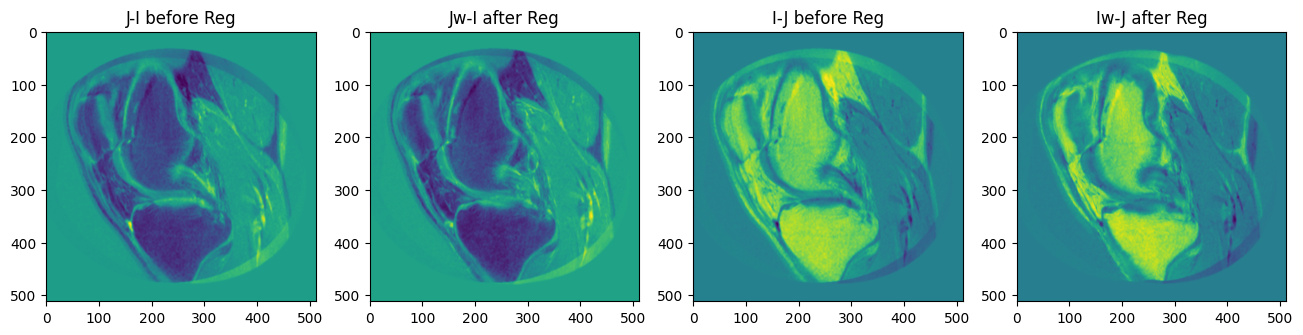

In [11]:
xyd = network(I_,J_,xy_,torch.zeros(1).to(device),1.0*torch.ones(1).to(device))

xyd_r = network(I_,J_,xy_,torch.zeros(1).to(device),-1.0*torch.ones(1).to(device))

Jw = F.grid_sample(J_,xyd,padding_mode='reflection',align_corners=True)
Iw = F.grid_sample(I_,xyd_r,padding_mode='reflection',align_corners=True)

%matplotlib inline
fig=plt.figure(figsize=(16,4))

fig.add_subplot(1,4,1)
plt.title("J-I before Reg")
plt.imshow((J_-I_).squeeze().cpu().data)

fig.add_subplot(1,4,2)
plt.imshow((Jw-I_).squeeze().cpu().data)
plt.title("Jw-I after Reg")

fig.add_subplot(1,4,3)
plt.title("I-J before Reg")
plt.imshow((I_-J_).squeeze().cpu().data)

fig.add_subplot(1,4,4)
plt.imshow((Iw-J_).squeeze().cpu().data)
plt.title("Iw-J after Reg")

plt.show()

### Do not edit the following cell

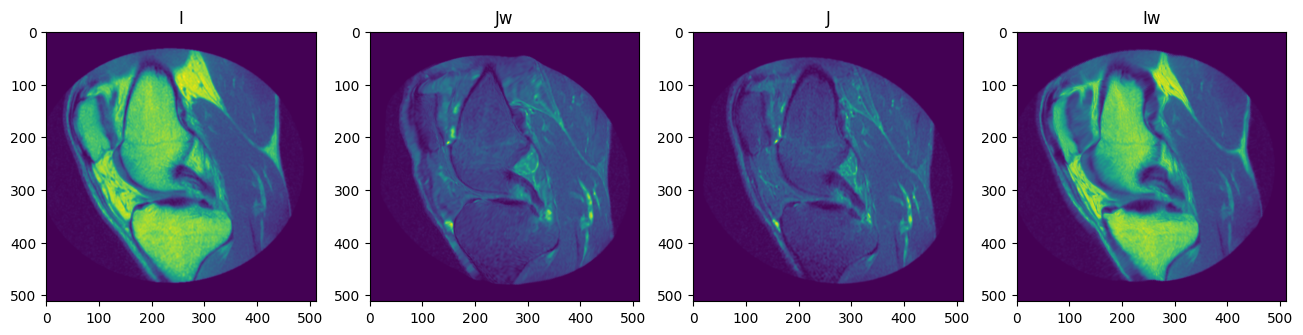

Max Difference Between Jw and I: 0.5759342908859253
Max Difference Between Iw and J: 0.7720850706100464
Mean, STD of the |Jw - I| 0.15075699985027313 0.2054387480020523
Mean, STD of the |Iw - J| 0.12547042965888977 0.1846080869436264


In [7]:
diff1 = (Iw - J_).abs()
diff2 = (Jw - I_).abs()

%matplotlib inline
fig=plt.figure(figsize=(16,4))

fig.add_subplot(1,4,1)
plt.title("I")
plt.imshow(I_.squeeze().cpu().data)

fig.add_subplot(1,4,2)
plt.imshow(Jw.squeeze().cpu().data)
plt.title("Jw")

fig.add_subplot(1,4,3)
plt.title("J")
plt.imshow(J_.squeeze().cpu().data)

fig.add_subplot(1,4,4)
plt.imshow(Iw.squeeze().cpu().data)
plt.title("Iw")

plt.show()
print('Max Difference Between Jw and I:', (Jw - I_).max().item())
print('Max Difference Between Iw and J:', (Iw - J_).max().item())
print('Mean, STD of the |Jw - I|',diff2.mean().item(), diff2.std().item())
print('Mean, STD of the |Iw - J|', diff1.mean().item(), diff1.std().item())

### Do not edit the following cell

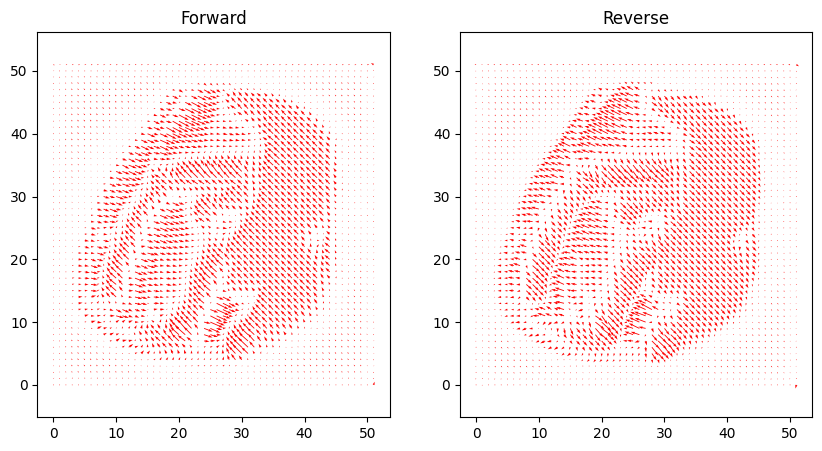

In [8]:
%matplotlib inline
df=10

%matplotlib inline

fig=plt.figure(figsize=(10,5))
d_ = (xyd - xy_).squeeze()
#fig=plt.figure(figsize=(5,5))
fig.add_subplot(1,2,1)
plt.quiver(d_.cpu().data[::df,::df,0], d_.cpu().data[::df,::df,1],color='r')
plt.axis('equal')
plt.title("Forward")

d__ = (xyd_r - xy_).squeeze()
#fig=plt.figure(figsize=(5,5))
fig.add_subplot(1,2,2)
plt.quiver(d__.cpu().data[::df,::df,0], d__.cpu().data[::df,::df,1],color='r')
plt.axis('equal')
plt.title("Reverse")
plt.show()

### Do not edit the following cell

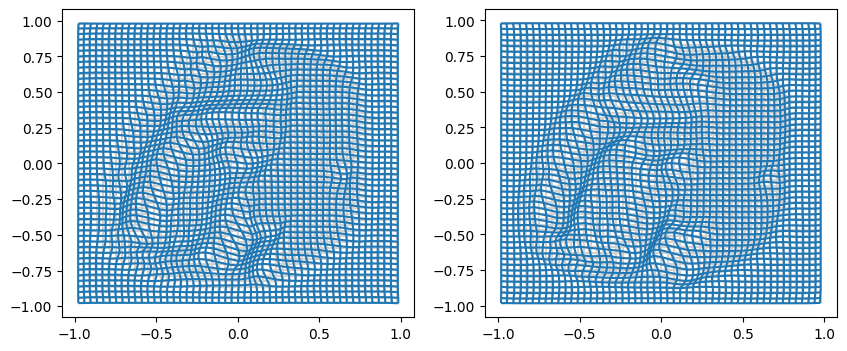

In [9]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

down_factor = 0.1
h_resize = int(down_factor*h_)
w_resize = int(down_factor*w_)

grid_x = resize(xy_.cpu()[:,:,:,0].squeeze().numpy(),(h_resize,w_resize))
grid_y = resize(xy_.cpu()[:,:,:,1].squeeze().numpy(),(h_resize,w_resize))
distx = resize(xyd.cpu()[:,:,:,0].squeeze().detach().numpy(),(h_resize,w_resize))
disty = resize(xyd.cpu()[:,:,:,1].squeeze().detach().numpy(),(h_resize,w_resize))
distx_ = resize(xyd_r.cpu()[:,:,:,0].squeeze().detach().numpy(),(h_resize,w_resize))
disty_ = resize(xyd_r.cpu()[:,:,:,1].squeeze().detach().numpy(),(h_resize,w_resize))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
plot_grid(grid_x,grid_y, ax=ax1,  color="lightgrey")
plot_grid(distx, disty, ax=ax1, color="C0")

plot_grid(grid_x,grid_y, ax=ax2,  color="lightgrey")
plot_grid(distx_, disty_, ax=ax2, color="C0")
plt.show()

## Do not edit the following cell

In [10]:
dx_dx = distx[1:-1,1:-1]-distx[1:-1,0:-2]
dx_dy = distx[1:-1,1:-1]-distx[0:-2,1:-1]
dy_dx = disty[1:-1,1:-1]-disty[1:-1,0:-2]
dy_dy = disty[1:-1,1:-1]-disty[0:-2,1:-1]

det = (dx_dx*dy_dy-dx_dy*dy_dx)<0.0
print("Percentage of folding in forward deformation:",100.*np.sum(det)/(dx_dx.shape[0]*dx_dx.shape[1]))

dxr_dx = distx_[1:-1,1:-1]-distx_[1:-1,0:-2]
dxr_dy = distx_[1:-1,1:-1]-distx_[0:-2,1:-1]
dyr_dx = disty_[1:-1,1:-1]-disty_[1:-1,0:-2]
dyr_dy = disty_[1:-1,1:-1]-disty_[0:-2,1:-1]

detr = (dxr_dx*dyr_dy-dxr_dy*dyr_dx)<0.0
print("Percentage of folding in backward deformation:",100.*np.sum(detr)/(dxr_dx.shape[0]*dxr_dx.shape[1]))

Percentage of folding in forward deformation: 0.0
Percentage of folding in backward deformation: 0.0
